# Efficacy Scores
Hertofor we have looked at attack statistics of a single attack and the probability of each result from the "fight to the death"

More versatile a metric would be to understand what is the expected outcome of attacking uphill or downhill. This would allow us to quickly build hurristics about how many troops to stack for an upcoming invader, and to answer the question "should we attack now, or hold our defenses"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.image as mpimg
import matplotlib.gridspec as grid_spec
# import scipy.stats as stats
import math

In [2]:
rng = np.random.default_rng()

# this rolls one n_dice with n_sides once each. 
def roll_dice(n_sides, n_dice):
    return (rng.integers(low = 1, high = n_sides, size = n_dice, endpoint=True)).tolist()


In [3]:
# Let's first get the confidence of a single attack, 3 attackers vs 2 defenders on flat ground.

def resolve_battle(a_rolls, d_rolls, debug=False):
    nad = len(a_rolls)
    ndd = len(d_rolls)
    min_die = min([nad, ndd])
    a_rolls.sort(reverse=True)
    d_rolls.sort(reverse=True)
    score = {'attack':0, 'defend':0, 'tracker':[]}
    if debug:
        print('a rolls: ', a_rolls)
        print('d rolls: ', d_rolls)
    for i in range(min_die):
        if a_rolls[i] > d_rolls[i]:
            score['defend'] -= 1
            score['tracker'].append(0)
        else:
            score['attack'] -= 1
            score['tracker'].append(1)
    if debug: print(score)
    return score   

In [4]:
score = resolve_battle(roll_dice(6, 3), roll_dice(6, 2), debug=True)

a rolls:  [6, 5, 1]
d rolls:  [5, 3]
{'attack': 0, 'defend': -2, 'tracker': [0, 0]}


In [5]:
def expected_score_new(n_a_dice, n_d_dice, n_throws=10000, n_a_sides=6, n_d_sides=6, debug = False):
    dice_fighting_per_round = min([n_a_dice, n_d_dice])
    attackers_lost = 0
    round_tracker = []
    for i in range(n_throws):
        this_round = resolve_battle(roll_dice(n_a_sides, n_a_dice), roll_dice(n_d_sides, n_d_dice))
        round_tracker += this_round['tracker']
        attackers_lost -= this_round['attack']
    if debug:
        print('attackers lost: ', attackers_lost)
        print('attackers wagered: ', (n_throws * dice_fighting_per_round))
        
    # get a histo of results
    # density normalizes for us
    # dispite appearances, this will make two buckets for us, one containing [0,1) and the other [1,2)
    bins = [0,1,2] 
    histo, edges = np.histogram(round_tracker, bins=bins,density=True)
    if debug: print('histo: ',histo)
    
    # expectation value = p = the probability mass found at 1
    expectation = histo[1]
    # standard deviation is sqrt(variance)
    # variance is just p(1-p)
    variance = expectation * (1- expectation)
    if debug:
        print('expectation: {0:.2f}'.format(expectation))
        print('variance: {0:.2f}'.format(variance))
  
    return expectation, variance, histo, edges

In [6]:
m, v, h, e = expected_score_new(2, 1, debug=True)

attackers lost:  4269
attackers wagered:  10000
histo:  [0.5731 0.4269]
expectation: 0.43
variance: 0.24


In [7]:
def c_of_n_x(n,x):
    numerator = math.factorial(n)
    denominator = math.factorial(x) * math.factorial(n-x)
    return numerator/denominator
    
def sample_binomial(p, n):
    distribution = [ c_of_n_x(n,z) * np.power(p, z) * np.power(1-p, n-z) for z in range(n+1)]
    return distribution

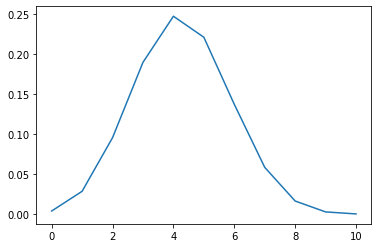

In [8]:
n_samples = 10
plt.plot(range(0,n_samples+1),sample_binomial(m, n_samples))
plt.show()

In [9]:
# make some data
n_throws = 10000
# number of bins. important to keep this small otherwise Bernoulli is 
# too confident / narrows out too much which is not reflected in our experiments
n_bins = 10

# specify tests we are going to run
scenarios = [
    (3,1, n_throws, 6, 6),
    (2,1, n_throws, 6, 6),
    (1,1, n_throws, 6, 6),
    (3,2, n_throws, 6, 6),
    (2,2, n_throws, 6, 6),
    (1,2, n_throws, 6, 6),
    (3,1, n_throws, 6, 7),
    (3,2, n_throws, 6, 7),
    (2,2, n_throws, 6, 7),
    (1,2, n_throws, 6, 7)
]
names = [
    '3 vs 1',
    '2 vs 1',
    '1 vs 1',
    '3 vs 2',
    '2 vs 2',
    '1 vs 2',
    '3 vs 1, Defender with 7 sides',
    '3 vs 2, Defender with 7 sides',
    '2 vs 2, Defender with 7 sides',
    '1 vs 2, Defender with 7 sides',
]
scenarios.reverse()
names.reverse()

# make some data to plot
x = range(n_bins+1)
y = []
c = []
cm = plt.cm.get_cmap('YlOrRd')
stats = []
for args in scenarios:
    m, s, h, e = expected_score_new(*args)
    stats.append( [m, s] )
    y += [ sample_binomial(m, n_bins) ]
    c += [cm(m)]

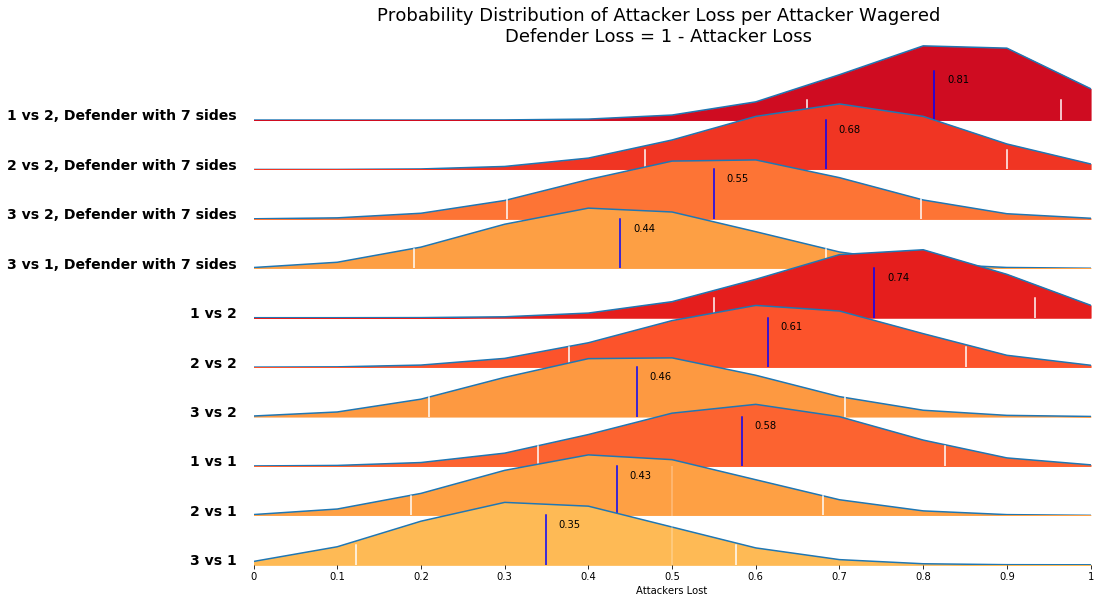

In [16]:
# plotting stuff
gs = (grid_spec.GridSpec(len(scenarios),1))

fig = plt.figure(figsize=(15,10))
fig.suptitle("Probability Distribution of Attacker Loss per Attacker Wagered\nDefender Loss = 1 - Attacker Loss", fontsize=18, y=0.9)
i=0

ax_objs = []
for name in names:
    # make a new axis and keep track of it in ax_objs
    ax_objs.append( fig.add_subplot(gs[i:i+1, 0:]) )
    ax = ax_objs[-1]
    # plot
    ax.plot(x, y[i])
    ax.fill_between(x,y[i], color = c[i])
    ymax=0.4
    ax.set_ylim(0,ymax)
    ax.set_xlim(0,10)
    # make background transparent
    rect = ax.patch
    rect.set_alpha(0)
    # remove borders, axis ticks, labels
    ax.set_yticks([])
    ax.set_ylabel('')
    if i != len(names)-1:
        ax.set_xticks([])
    else:
        ax.set_xticks(range(0,n_bins+1))
        ax.set_xticklabels([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
        ax.set_xlabel("Attackers Lost")
        ax.axvline(x=n_bins*.5, ymin=0, ymax=(len(names)*ymax), alpha = .3, color='w')
    for s in ['top','right','left','bottom']:
        ax.spines[s].set_visible(False) 
    ax.text(-0.2,0,name, fontweight='bold',fontsize=14,ha='right')
    ax.axvline(x=stats[i][0]*n_bins, ymin=0, ymax=.5, color='b')
    ax.axvline(x=(stats[i][0] * n_bins + stats[i][1]*n_bins), ymin=0, ymax=.2, color='w')
    ax.axvline(x=(stats[i][0] * n_bins - stats[i][1]*n_bins), ymin=0, ymax=.2, color='w')
    ax.text((stats[i][0]*n_bins + .15), 0.15 ,'{0:.2f}'.format(stats[i][0]))
    i +=1
# make plots overlap eachother
gs.update(hspace= -.5)
    
plt.show()